In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.misc
from scipy.special import comb
import sys
np.set_printoptions(threshold=sys.maxsize, suppress = True) # for printing the whole numpy array

In [2]:
def compute_updated_exp_val(current_score, N, p, i, j):
    
    """
    Returns <log f>_g as of the entries in the n_matrix
    """
    
    global contrib_msg_to_score
    
    # what has got invalidated is the component resulting from the ith message
    
    updated_score = current_score - msg_probs[i] * math.log2(contrib_msg_to_score[i])
    updated_score += msg_probs[i] * math.log2(contrib_msg_to_score[i] + (p ** j) * ((1 - p)) ** (N - j))
    return updated_score

In [3]:
N = 5
L = 2 ** N # for now, say

In [7]:
M = 4
pvals = [0.40]
# pvals = list(np.arange(0.05, 0.46, 0.03))
high_noises = [0.10]

high_noise_order_matrix = np.zeros((M, N + 1))
actual_noise_order_matrix = np.zeros((M, N + 1))

#tvals = list(np.arange(0.5, 3.1, 0.5))
tvals = [2]
#tvals = [3] # for testing

In [5]:
limits = np.array([comb(N, k, exact = True) for k in range(0, N + 1)])
contrib_msg_to_score = [0] * M # contribution of each message to the score

In [8]:
# TO OUTPUT THE ORDER OF FILLING

for t in tvals:
    
    for high_noise in high_noises:
    
        contrib_msg_to_score = [0] * M # contribution of each message to the score
        
        msg_probs = np.array([(1/j) ** t for j in range(1, M + 1)])
        #    msg_probs = np.array([1.0] * M)   # for sanity checks
        msg_probs = list(msg_probs)
        msg_probs.sort(reverse = True)
        msg_probs = np.array(msg_probs)
        sum_probs = sum(msg_probs)
        msg_probs /= sum_probs
        
        prepn_for_worst_case = []
        actual_achievable = []
        
        print('Computing for t =', t, '...')
        
        # compute for high noise regime
        
        p = high_noise  # for now
        high_noise_str = "{:.2f}".format(high_noise)  # had to do this because 0.150000000000001 etc
            
        high_noise_matrix = np.zeros((M, N + 1))
        filled_vol = 0
    
        # at least one must go into every message
        # otherwise 'log will kill you'
        
        # WLOG assume p < 0.5
        # so it's better to put everything in everything's first one itself
        
        current_score = 0
        
        print('Noise p order of filling:')
        
        for i in range(M):
            high_noise_matrix[i][0] = 1
            filled_vol += 1
            high_noise_order_matrix[i][0] = filled_vol
            # populate contrib_msg_to_score
            contrib_msg_to_score[i] = (1 - p) ** N
            current_score += msg_probs[i] * math.log2(contrib_msg_to_score[i])
    
        while filled_vol < L:
            best_gain = -float('inf')
            best_gain_indices = (-1, -1)
            for i in range(M):
                for j in range(N + 1):
                    # search space is always M * (N + 1)
                    if high_noise_matrix[i][j] == limits[j]:
                        continue
                    new_score = compute_updated_exp_val(current_score, N, p, i, j)
                    if new_score - current_score > best_gain:
                        best_gain = new_score - current_score
                        best_gain_indices = (i, j)
            i_index, j_index = best_gain_indices
            contrib_msg_to_score[i_index] += (p ** j_index) * ((1 - p) ** (N - j_index))
            high_noise_matrix[i_index][j_index] += 1
            current_score += best_gain
            filled_vol += 1
            high_noise_order_matrix[i_index][j_index] = filled_vol
            print(high_noise_order_matrix)
        
        print('--------------------------------------')
        print('Actual achievable order of filling:')
            
        # do for all the other (actual) channel noise bit flip probabilities
        
        for p in pvals:
            
            p_str = "{:.2f}".format(p)  # had to do this because 0.150000000000001 etc
            
            n_matrix = np.zeros((M, N + 1))
            filled_vol = 0
        
            # at least one must go into every message
            # otherwise 'log will kill you'
            
            # WLOG assume p < 0.5
            # so it's better to put everything in everything's first one itself
            
            current_score = 0
            
            for i in range(M):
                n_matrix[i][0] = 1
                filled_vol += 1
                actual_noise_order_matrix[i][0] = filled_vol
                # populate contrib_msg_to_score
                contrib_msg_to_score[i] = (1 - p) ** N
                current_score += msg_probs[i] * math.log2(contrib_msg_to_score[i])
        
            while filled_vol < L:
                best_gain = -float('inf')
                best_gain_indices = (-1, -1)
                for i in range(M):
                    for j in range(N + 1):
                        # search space is always M * (N + 1)
                        if n_matrix[i][j] == limits[j]:
                            continue
                        new_score = compute_updated_exp_val(current_score, N, p, i, j)
                        if new_score - current_score > best_gain:
                            best_gain = new_score - current_score
                            best_gain_indices = (i, j)
                i_index, j_index = best_gain_indices
                contrib_msg_to_score[i_index] += (p ** j_index) * ((1 - p) ** (N - j_index))
                n_matrix[i_index][j_index] += 1
                current_score += best_gain
                filled_vol += 1
                actual_noise_order_matrix[i_index][j_index] = filled_vol
                print(actual_noise_order_matrix)
                            
            # compute <log f> for that p with the answer to high noise configuration
            
            high_noise_exp_val = 0.0
            
            for j in range(M):
                val = 0.0
                for k in range(N + 1):
                    val += high_noise_matrix[j][k] * (p ** k) * ((1 - p) ** (N - k))
                high_noise_exp_val += msg_probs[j] * math.log2(val)
                                                               
            print('Perf exp val =', high_noise_exp_val)
                    
            actual_exp_val = 0.0
            
            for j in range(M):
                val = 0.0
                for k in range(N + 1):
                    val += n_matrix[j][k] * (p ** k) * ((1 - p) ** (N - k))
                actual_exp_val += msg_probs[j] * math.log2(val)
            
            print('Actual exp val =', actual_exp_val)
                    
            prepn_for_worst_case.append(high_noise_exp_val)
            actual_achievable.append(actual_exp_val)

Computing for t = 2 ...
Noise p order of filling:
[[1. 5. 0. 0. 0. 0.]
 [2. 0. 0. 0. 0. 0.]
 [3. 0. 0. 0. 0. 0.]
 [4. 0. 0. 0. 0. 0.]]
[[1. 6. 0. 0. 0. 0.]
 [2. 0. 0. 0. 0. 0.]
 [3. 0. 0. 0. 0. 0.]
 [4. 0. 0. 0. 0. 0.]]
[[1. 7. 0. 0. 0. 0.]
 [2. 0. 0. 0. 0. 0.]
 [3. 0. 0. 0. 0. 0.]
 [4. 0. 0. 0. 0. 0.]]
[[1. 8. 0. 0. 0. 0.]
 [2. 0. 0. 0. 0. 0.]
 [3. 0. 0. 0. 0. 0.]
 [4. 0. 0. 0. 0. 0.]]
[[1. 9. 0. 0. 0. 0.]
 [2. 0. 0. 0. 0. 0.]
 [3. 0. 0. 0. 0. 0.]
 [4. 0. 0. 0. 0. 0.]]
[[ 1.  9.  0.  0.  0.  0.]
 [ 2. 10.  0.  0.  0.  0.]
 [ 3.  0.  0.  0.  0.  0.]
 [ 4.  0.  0.  0.  0.  0.]]
[[ 1.  9.  0.  0.  0.  0.]
 [ 2. 11.  0.  0.  0.  0.]
 [ 3.  0.  0.  0.  0.  0.]
 [ 4.  0.  0.  0.  0.  0.]]
[[ 1.  9.  0.  0.  0.  0.]
 [ 2. 12.  0.  0.  0.  0.]
 [ 3.  0.  0.  0.  0.  0.]
 [ 4.  0.  0.  0.  0.  0.]]
[[ 1.  9.  0.  0.  0.  0.]
 [ 2. 13.  0.  0.  0.  0.]
 [ 3.  0.  0.  0.  0.  0.]
 [ 4.  0.  0.  0.  0.  0.]]
[[ 1.  9.  0.  0.  0.  0.]
 [ 2. 14.  0.  0.  0.  0.]
 [ 3.  0.  0.  0.  0.  0.]
 [ 4.  0

Computing for t = 2 ...


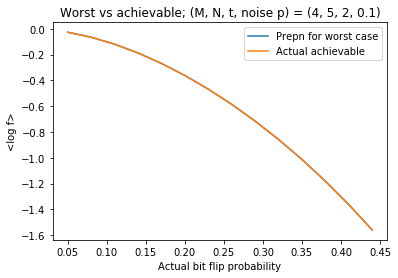

In [11]:
# TO COMPARE 

pvals = list(np.arange(0.05, 0.46, 0.03))

for t in tvals:
    
    for high_noise in high_noises:
    
        contrib_msg_to_score = [0] * M # contribution of each message to the score
        
        msg_probs = np.array([1 / M for j in range(1, M + 1)])
        #    msg_probs = np.array([1.0] * M)   # for sanity checks
        msg_probs = list(msg_probs)
        msg_probs.sort(reverse = True)
        msg_probs = np.array(msg_probs)
        sum_probs = sum(msg_probs)
        msg_probs /= sum_probs
        
        prepn_for_worst_case = []
        actual_achievable = []
        
        print('Computing for t =', t, '...')
        
        # compute for high noise regime
        
        p = high_noise  # for now
        high_noise_str = "{:.2f}".format(high_noise)  # had to do this because 0.150000000000001 etc
            
        high_noise_matrix = np.zeros((M, N + 1))
        filled_vol = 0
    
        # at least one must go into every message
        # otherwise 'log will kill you'
        
        # WLOG assume p < 0.5
        # so it's better to put everything in everything's first one itself
        
        current_score = 0
        
        for i in range(M):
            high_noise_matrix[i][0] = 1
            filled_vol += 1
            # populate contrib_msg_to_score
            contrib_msg_to_score[i] = (1 - p) ** N
            current_score += msg_probs[i] * math.log2(contrib_msg_to_score[i])
    
        while filled_vol < L:
            best_gain = -float('inf')
            best_gain_indices = (-1, -1)
            for i in range(M):
                for j in range(N + 1):
                    # search space is always M * (N + 1)
                    if high_noise_matrix[i][j] == limits[j]:
                        continue
                    new_score = compute_updated_exp_val(current_score, N, p, i, j)
                    if new_score - current_score > best_gain:
                        best_gain = new_score - current_score
                        best_gain_indices = (i, j)
            i_index, j_index = best_gain_indices
            contrib_msg_to_score[i_index] += (p ** j_index) * ((1 - p) ** (N - j_index))
            high_noise_matrix[i_index][j_index] += 1
            current_score += best_gain
            filled_vol += 1
            
        # do for all the other (actual) channel noise bit flip probabilities
        
        for p in pvals:
            
            p_str = "{:.2f}".format(p)  # had to do this because 0.150000000000001 etc
            
            n_matrix = np.zeros((M, N + 1))
            filled_vol = 0
        
            # at least one must go into every message
            # otherwise 'log will kill you'
            
            # WLOG assume p < 0.5
            # so it's better to put everything in everything's first one itself
            
            current_score = 0
            
            for i in range(M):
                n_matrix[i][0] = 1
                filled_vol += 1
                # populate contrib_msg_to_score
                contrib_msg_to_score[i] = (1 - p) ** N
                current_score += msg_probs[i] * math.log2(contrib_msg_to_score[i])
        
            while filled_vol < L:
                best_gain = -float('inf')
                best_gain_indices = (-1, -1)
                for i in range(M):
                    for j in range(N + 1):
                        # search space is always M * (N + 1)
                        if n_matrix[i][j] == limits[j]:
                            continue
                        new_score = compute_updated_exp_val(current_score, N, p, i, j)
                        if new_score - current_score > best_gain:
                            best_gain = new_score - current_score
                            best_gain_indices = (i, j)
                i_index, j_index = best_gain_indices
                contrib_msg_to_score[i_index] += (p ** j_index) * ((1 - p) ** (N - j_index))
                n_matrix[i_index][j_index] += 1
                current_score += best_gain
                filled_vol += 1
    
            
            # compute <log f> for that p with the answer to high noise configuration
            
            high_noise_exp_val = 0.0
            
            for j in range(M):
                val = 0.0
                for k in range(N + 1):
                    val += high_noise_matrix[j][k] * (p ** k) * ((1 - p) ** (N - k))
                high_noise_exp_val += msg_probs[j] * math.log2(val)
                    
            actual_exp_val = 0.0
            
            for j in range(M):
                val = 0.0
                for k in range(N + 1):
                    val += n_matrix[j][k] * (p ** k) * ((1 - p) ** (N - k))
                actual_exp_val += msg_probs[j] * math.log2(val)
                    
            prepn_for_worst_case.append(high_noise_exp_val)
            actual_achievable.append(actual_exp_val)
            
        plt.plot(pvals, prepn_for_worst_case)
        plt.plot(pvals, actual_achievable)
        
        # code for individual plots below      
        
        plt.title('Worst vs achievable; (M, N, t, noise p) = ' + str(tuple([M, N, t, float(high_noise_str)])))
        plt.xlabel('Actual bit flip probability')
        plt.ylabel('<log f>')
        plt.legend(['Prepn for worst case', 'Actual achievable'])
#         plt.savefig('Plots/PrepnForWorstFixedT/Greedy/ylim-' + high_noise_str + '-' + str(t) +'.svg', format='svg', dpi=1200)
        plt.show()